# Comparison of (penalized) Logistic Regression and K-Nearest-Neighbors (KNN) on MNIST digits

This mini project will compare the performance. characteristics, and implementations of the two commonly used classifiers, namely Logistic Regression and k-Nearest Neighbors. The data we will be working with are hand-written MNIST digit of 4s and 9s, represented as `28x28` pixel arrays. There will be two training sets: `mnist_train`, which contains 80 examples of each class, and `mnist_train_small`, which contains 5 examples of each class. There is also a validation set `mnist_valid` that we will use for model selection, and a test set `mnist_test` for the final testing.

## KNN Implementation

In [27]:
#setup
import numpy as np
import matplotlib.pyplot as plt
import math

Implement the function that computes the Euclidean distance matrix between the image $a$ and $b$.

In [2]:
def l2_distance(a, b):
    if a.shape[0] != b.shape[0]:
        raise ValueError("A and B should be of same dimensionality")
    aa = np.sum(a**2, axis=0)
    bb = np.sum(b**2, axis=0)
    ab = np.dot(a.T, b)
    return np.sqrt(aa[:, np.newaxis] + bb[np.newaxis, :] - 2*ab)

Load the MNIST digits datasets.

In [4]:
def load_train():
    """Loads training data."""
    with open('mnist_train.npz', 'rb') as f:
        train_set = np.load(f)
        train_inputs = train_set['train_inputs']
        train_targets = train_set['train_targets']
    return train_inputs, train_targets 

def load_train_small():
    """Loads small training data."""
    with open('mnist_train_small.npz', 'rb') as f:
        train_set_small = np.load(f)
        train_inputs_small = train_set_small['train_inputs_small']
        train_targets_small = train_set_small['train_targets_small']
    return train_inputs_small, train_targets_small

def load_valid():
    """Loads validation data."""
    with open('mnist_valid.npz', 'rb') as f:
        valid_set = np.load(f)
        valid_inputs = valid_set['valid_inputs']
        valid_targets = valid_set['valid_targets']
    return valid_inputs, valid_targets 

def load_test():
    """Loads test data."""
    with open('mnist_test.npz', 'rb') as f:
        test_set = np.load(f)
        test_inputs = test_set['test_inputs']
        test_targets = test_set['test_targets']
    return test_inputs, test_targets 

Implement `extract_digits` that returns a list of 28 x 28 pixel intensity arrays starting at `start_index` and ending at `end_index`.

In [5]:
def extract_digits(digit_array, start_index, end_index):
    digits = []
    for index in range(int(start_index), int(end_index)):
        digits.append(extract_digit_pixels(digit_array, index))
    return digits

Extracts the 28 x 28 pixel intensity array at the specified index.

In [6]:
def extract_digit_pixels(digit_array, index):
    return digit_array[index].reshape(28, 28)

Displays two rows of digits on the screen.

In [7]:
def show_pane(top_digits, bottom_digits):
    all_digits = top_digits + bottom_digits
    fig, axes = plt.subplots(nrows = 2, ncols = len(all_digits)//2)
    for axis, digit in zip(axes.reshape(-1), all_digits):
        axis.imshow(digit, interpolation='nearest', cmap=plt.gray())
        axis.axis('off')
    plt.show()

Implement the function `plot_digits` to visualizes each example in `digit_array`.

In [8]:
def plot_digits(digit_array):
    """
    Note: N is the number of examples 
          and M is the number of features per example.
    Inputs:
        digits: N x M array of pixel intensities.
    """
    CLASS_EXAMPLES_PER_PANE = 5

    # assume two evenly split classes
    examples_per_class = digit_array.shape[0]/2
    num_panes = int(np.ceil(float(examples_per_class)/CLASS_EXAMPLES_PER_PANE))

    for pane in range(num_panes):
        print("Displaying pane {}/{}".format(pane+1, num_panes))

        top_start = pane*CLASS_EXAMPLES_PER_PANE
        top_end = min((pane+1)*CLASS_EXAMPLES_PER_PANE, examples_per_class)
        top_pane_digits = extract_digits(digit_array, top_start, top_end)

        bottom_start = top_start + examples_per_class
        bottom_end = top_end + examples_per_class
        bottom_pane_digits = extract_digits(digit_array, bottom_start, bottom_end)
        show_pane(top_pane_digits, bottom_pane_digits)

Example of plotting a digit from `load_train_small`

Displaying pane 1/1


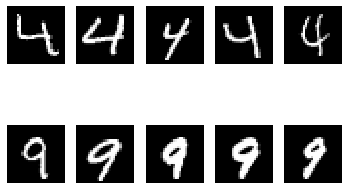

In [9]:
plot_digits(load_train_small()[0])

Corresponding lables of `load_train_small`

In [10]:
load_train_small()[1]

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]])

## KNN Execution

Implement the main function for KNN, `run_knn` that uses the supplied training inputs and labels to make predictions for validation data using the K-nearest neighbours algorithm.

In [11]:
def run_knn(k, train_data, train_labels, valid_data):
    """
    Note: N_TRAIN is the number of training examples,
          N_VALID is the number of validation examples, 
          and M is the number of features per example.
    Inputs:
        k:            The number of neighbours to use for classification 
                      of a validation example.
        train_data:   The N_TRAIN x M array of training
                      data.
        train_labels: The N_TRAIN x 1 vector of training labels
                      corresponding to the examples in train_data 
                      (must be binary).
        valid_data:   The N_VALID x M array of data to
                      predict classes for.
    Outputs:
        valid_labels: The N_VALID x 1 vector of predicted labels 
                      for the validation data.
    """

    dist = l2_distance(valid_data.T, train_data.T)
    nearest = np.argsort(dist, axis=1)[:,:k]

    train_labels = train_labels.reshape(-1)
    valid_labels = train_labels[nearest]

    # note this only works for binary labels
    valid_labels = (np.mean(valid_labels, axis=1) >= 0.5).astype(np.int)
    valid_labels = valid_labels.reshape(-1,1)

    return valid_labels

Run `kNN` for different values of $k \in \{1, 3, 5, 7, 9\}$ and plot the classification rate on the validation set (number of correctly predicted cases, divided by total number of data points) as a function of `k`.

In [12]:
train_inputs, train_targets = load_train()
valid_inputs, valid_targets = load_valid()
test_inputs, test_targets = load_test()

set_k = [1,3,5,7,9]

accuracy_valid_output = {}
accuracy_test_output = {}

length_valid = len(valid_inputs)
length_test = len(test_inputs)
for k in set_k:
    valid_outputs = run_knn(k, train_inputs, train_targets, valid_inputs)
    test_outputs =  run_knn(k, train_inputs, train_targets, test_inputs)

    count_valid = np.sum(valid_outputs == valid_targets) 
    accuracy_valid = count_valid/length_valid
    accuracy_valid_output["k="+str(k)] = accuracy_valid

    count_test = np.sum(test_outputs == test_targets) 
    accuracy_test = count_test/length_test
    accuracy_test_output["k="+str(k)] = accuracy_test

Validation Accuracy:

In [13]:
accuracy_valid_output

{'k=1': 0.82, 'k=3': 0.86, 'k=5': 0.86, 'k=7': 0.86, 'k=9': 0.84}

Test Accuracy

In [14]:
accuracy_test_output

{'k=1': 0.88, 'k=3': 0.92, 'k=5': 0.94, 'k=7': 0.94, 'k=9': 0.88}

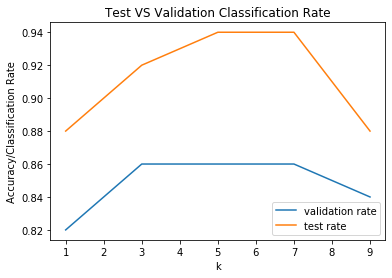

In [17]:
plt.plot(set_k, list(accuracy_valid_output.values()), label="validation rate")
plt.plot(set_k, list(accuracy_test_output.values()), label="test rate")

plt.title("Test VS Validation Classification Rate")
plt.xlabel("k")
plt.ylabel("Accuracy/Classification Rate")
plt.legend()
plt.savefig("Test Set VS Validation Rates of KNN.png")

### Comments on the performance and which value of k* to choose from:

Although the $k$ value of $5$ and $7$ has the same classification rate for both test and validation data set, I would choose $k^*$ to be $5$. This is because having choosing $k^* = 5$, $k^*-2 = 3$ and $k^*+2 = 7$ also outputs the highest classification rate (for both test and validation) compared to all other values for $k^*$. This might suggest that this value of $k^*$ would also perform better in different data sets (as shown by the figure above).

However, the classification rate for validation and test set does not correspond, for example, for $k=3$ and $k=5$, they both have the classification rate of $0.86$ on validation set, the performance on test set is $0.92$ and $0.94$, respectively. This is likely to be caused by the different labelled data set provided to training and validation data (since both their sample size is 50 while the sample size for training set is 160). This causes the classification rate for test set to be consistently higher than that of all validation set.

## Logisitic Regression

Now, we will perform the experiment with the same MNIST datasets using logisitic regression on both `mnist_train` and `mnist_train_small` datasets, and attempt to choose the best hyperparameters for the `learning rate`, the `number of iterations`, and the way in which we initialize the `weights`.

Computes the element wise logistic sigmoid of $x$.

In [3]:
def sigmoid(x):
    """
    Inputs:
        x: Either a row vector or a column vector.
    """
    return 1.0 / (1.0 + np.exp(-x))

Implement the `logistic_predict` function to compute the probabilities predicted by the logistic classifier.

In [48]:
def logistic_predict(weights, data):
    """
    Note: N is the number of examples and
          M is the number of features per example.

    Inputs:
        weights:    (M+1) x 1 vector of weights, where the last element
                    corresponds to the bias (intercepts).
        data:       N x M data matrix where each row corresponds
                    to one data point.
    Outputs:
        y:          :N x 1 vector of probabilities. This is the output of the classifier.
    """
    b = weights[-1]
    y = sigmoid(np.dot(data, weights[:-1]) + b)
    return y

Compute evaluation metrics.

In [47]:
def evaluate(targets, y):
    """
    Inputs:
        targets : N x 1 vector of targets.
        y       : N x 1 vector of probabilities.
    Outputs:
        ce           : (scalar) Cross entropy. CE(p, q) = E_p[-log q]. Here we want to compute CE(targets, y)
        frac_correct : (scalar) Fraction of inputs classified correctly.
    """
    ce = - np.dot(np.transpose(targets), np.log(y)) #
    frac_correct = (targets == (y > 0.5)).mean()  #
    return ce, frac_correct

Calculate negative log likelihood and its derivatives with respect to weights and also return the predictions.

In [32]:
def logistic(weights, data, targets, hyperparameters):
    """
    Note: N is the number of examples and
          M is the number of features per example.
    Inputs:
        weights:    (M+1) x 1 vector of weights, where the last element
                    corresponds to bias (intercepts).
        data:       N x M data matrix where each row corresponds
                    to one data point.
        targets:    N x 1 vector of targets class probabilities.
        hyperparameters: The hyperparameters dictionary.
    Outputs:
        f:       The sum of the loss over all data points. This is the objective that we want to minimize.
        df:      (M+1) x 1 vector of derivative of f w.r.t. weights.
        y:       N x 1 vector of probabilities.
    """  
    y = logistic_predict(weights, data) #after sigmoid transformation
    #compute f and df without regularization
    f = 0
    for i in range(len(y)): #y is vector of n elements
        f += (-targets[i]*math.log(y[i])) - (1-targets[i])*math.log(1-y[i]) #by formula of L_CE
        
    product = data.T.dot(y-targets)
    #add vector of sum([y-targets]) to the last row to make df to size (M+1) x 1
    df = np.append(product, [[np.sum(y-targets)]], axis = 0) 
    return f, df, y

Performs a simple gradient check on logistic function.

In [126]:
def check_grad(func, X, epsilon, *args):
    """
    checks the derivatives in a function, by comparing them to finite
    differences approximations. The partial derivatives and the approximation
    are printed and the norm of the diffrence divided by the norm of the sum is
    returned as an indication of accuracy.
    usage: checkgrad(func, X, epsilon, P1, P2, ...)
    where X is the argument and epsilon is the small perturbation used for the finite
    differences. and the P1, P2, ... are optional additional parameters which
    get passed to f. The function f should be of the type
    (fX, dfX) = func(X, P1, P2, ...)
    where fX is the function value and dfX is a vector of partial derivatives.
    Original Author: Carl Edward Rasmussen, 2001-08-01.
    Ported to Python 2.7 by JCS (9/21/2013).
    """
    if len(X.shape) != 2 or X.shape[1] != 1:
        raise ValueError("X must be a vector")
    y, dy, = func(X, *args)[:2]         # get the partial derivatives dy
    dh = np.zeros((len(X), 1))
    for j in range(len(X)):
        dx = np.zeros((len(X), 1))
        dx[j] += epsilon
        y2 = func(X+dx, *args)[0]
        dx = -dx
        y1 = func(X+dx, *args)[0]
        dh[j] = (y2 - y1)/(2*epsilon)
#     print(np.hstack((dy, dh)))         # print the two vectors
    d = np.linalg.norm(dh-dy)/np.linalg.norm(dh+dy)  # return norm of diff divided by norm of sum
    return d

def run_check_grad(hyperparameters):
    # This creates small random data with 20 examples and
    # 10 dimensions and checks the gradient on that data.
    num_examples = 20
    num_dimensions = 10
    weights = np.random.randn(num_dimensions+1, 1)
    data    = np.random.randn(num_examples, num_dimensions)
    targets = np.random.rand(num_examples, 1)

    diff = check_grad(logistic,      # function to check
                      weights,
                      0.001,         # perturbation
                      data,
                      targets,
                      hyperparameters)
    print("check_grad diff (should be close to 0)=", diff)

## Execution

In [123]:
def run_logistic_regression(learning_rate, num_iterations, stats_on=True):
    train_inputs, train_targets = load_train()
    #train_inputs, train_targets = load_train_small()
    valid_inputs, valid_targets = load_valid()
    N, M = train_inputs.shape

    # Set hyperparameters
    hyperparameters = {
                    'learning_rate': learning_rate,
                    'weight_regularization': 1,
                    'num_iterations':num_iterations
                 }

    # Logistic regression weights
    # Initialize to random weights here.
    weights = np.random.randn(M + 1, 1) /10

    # Verify that your logistic function produces the right gradient.
    # diff should be very close to 0.
    run_check_grad(hyperparameters)

    ce_train = []
    ce_test = []
    fc_train = []
    fc_test = []

    # Begin learning with gradient descent
    for t in range(hyperparameters['num_iterations']):

        # Find the negative log likelihood and its derivatives w.r.t. the weights.
        f, df, predictions = logistic(weights, train_inputs, train_targets, hyperparameters)

        # Evaluate the prediction.
        cross_entropy_train, frac_correct_train = evaluate(train_targets, predictions)

        if np.isnan(f) or np.isinf(f):
            raise ValueError("nan/inf error")

        # update parameters
        weights = weights - hyperparameters['learning_rate'] * df / N

        # Make a prediction on the valid_inputs.
        predictions_valid = logistic_predict(weights, valid_inputs)

        # Evaluate the prediction.
        cross_entropy_valid, frac_correct_valid = evaluate(valid_targets, predictions_valid)

        # print stats if stats_on is True
        if stats_on:
            print(("ITERATION:{:4d}  TRAIN NLOGL:{:4.2f}  TRAIN CE:{:.6f} "
                   "TRAIN FRAC:{:2.2f}  VALID CE:{:.6f}  VALID FRAC:{:2.2f}").format(
                       (t+1), float(f / N), float(cross_entropy_train), float(frac_correct_train*100),
                       float(cross_entropy_valid), float(frac_correct_valid*100)))

        ce_train = np.append(ce_train, cross_entropy_train)
        ce_test = np.append(ce_test, cross_entropy_valid)
        fc_train = np.append(fc_train, frac_correct_train)
        fc_test = np.append(fc_test, frac_correct_valid)

    plt.plot(ce_train, label = "training set")
    plt.plot(ce_test, label = "validation set")
    plt.title("Cross Entropy with small training set using \n learning rate "+ str(hyperparameters['learning_rate'])+
              " and " + str(hyperparameters['num_iterations']) + " iterations")
    plt.legend()
    plt.show()
    plt.plot(fc_train, label = "training set")
    plt.plot(fc_test, label = "validation set")
    plt.title("Fraction Correctness with small training set using \n learning rate "+ str(hyperparameters['learning_rate'])+
          " and " + str(hyperparameters['num_iterations']) + " iterations")
    plt.show()

check_grad diff (should be close to 0)= 1.4767455838815206e-08
ITERATION:   1  TRAIN NLOGL:-69.20  TRAIN CE:43.666864 TRAIN FRAC:59.38  VALID CE:13.696274  VALID FRAC:64.00
ITERATION:   2  TRAIN NLOGL:-71.14  TRAIN CE:44.848879 TRAIN FRAC:63.75  VALID CE:13.024140  VALID FRAC:66.00
ITERATION:   3  TRAIN NLOGL:-67.48  TRAIN CE:42.536077 TRAIN FRAC:69.38  VALID CE:12.339723  VALID FRAC:70.00
ITERATION:   4  TRAIN NLOGL:-63.72  TRAIN CE:40.166744 TRAIN FRAC:71.88  VALID CE:11.739323  VALID FRAC:68.00
ITERATION:   5  TRAIN NLOGL:-60.37  TRAIN CE:38.053321 TRAIN FRAC:78.12  VALID CE:11.218161  VALID FRAC:74.00
ITERATION:   6  TRAIN NLOGL:-57.41  TRAIN CE:36.186706 TRAIN FRAC:81.25  VALID CE:10.763664  VALID FRAC:74.00
ITERATION:   7  TRAIN NLOGL:-54.78  TRAIN CE:34.531452 TRAIN FRAC:83.12  VALID CE:10.364722  VALID FRAC:76.00
ITERATION:   8  TRAIN NLOGL:-52.44  TRAIN CE:33.055392 TRAIN FRAC:85.62  VALID CE:10.012250  VALID FRAC:78.00
ITERATION:   9  TRAIN NLOGL:-50.34  TRAIN CE:31.731740 TR

ITERATION: 104  TRAIN NLOGL:-15.23  TRAIN CE:9.596777 TRAIN FRAC:99.38  VALID CE:5.014621  VALID FRAC:86.00
ITERATION: 105  TRAIN NLOGL:-15.14  TRAIN CE:9.540489 TRAIN FRAC:99.38  VALID CE:5.005160  VALID FRAC:86.00
ITERATION: 106  TRAIN NLOGL:-15.05  TRAIN CE:9.484949 TRAIN FRAC:99.38  VALID CE:4.995849  VALID FRAC:86.00
ITERATION: 107  TRAIN NLOGL:-14.96  TRAIN CE:9.430143 TRAIN FRAC:99.38  VALID CE:4.986686  VALID FRAC:86.00
ITERATION: 108  TRAIN NLOGL:-14.88  TRAIN CE:9.376053 TRAIN FRAC:99.38  VALID CE:4.977667  VALID FRAC:86.00
ITERATION: 109  TRAIN NLOGL:-14.79  TRAIN CE:9.322664 TRAIN FRAC:99.38  VALID CE:4.968789  VALID FRAC:86.00
ITERATION: 110  TRAIN NLOGL:-14.71  TRAIN CE:9.269962 TRAIN FRAC:99.38  VALID CE:4.960048  VALID FRAC:86.00
ITERATION: 111  TRAIN NLOGL:-14.63  TRAIN CE:9.217931 TRAIN FRAC:99.38  VALID CE:4.951442  VALID FRAC:86.00
ITERATION: 112  TRAIN NLOGL:-14.55  TRAIN CE:9.166558 TRAIN FRAC:99.38  VALID CE:4.942968  VALID FRAC:86.00
ITERATION: 113  TRAIN NLOGL:

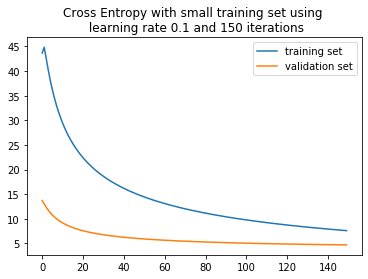

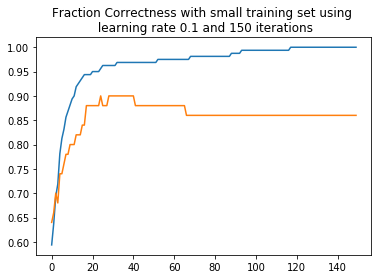

In [128]:
run_logistic_regression(0.1, 150)